Creation of the dataset for classification.
=================

For the CNN and Tranfer learning we will divide the original dataset "yelp_photos" into three parts the train, test and validation datasets. In this notebook we are only creating the data

In [10]:
#Import the required libraries
import os
import numpy as np 
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2 as cv
from pathlib import Path
import shutil
import random
import matplotlib.image as mpimg
import PIL
import PIL.Image

from PIL import Image, ImageFilter, ImageTk
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Data preparation

In [2]:
data = pd.read_json('yelp_photos/photos.json', lines=True)

In [3]:
len(data)

200000

There are 200K images in the dataset.

In [4]:
chunks=pd.read_json('yelp_photos/photos.json', lines=True, chunksize=2000)

In [5]:
df = pd.DataFrame(columns=['photo_id', 'label'])
x = 0
for chunk in chunks:
    if(x == 0):
        if ((chunk.iloc[0].label == 'drink') & len(chunk.label.value_counts()) == 1):
            df = pd.concat([df, chunk])   
            x = x + 1
    if(x == 1):    
        if ((chunk.iloc[0].label == 'food') & len(chunk.label.value_counts()) == 1):
            df = pd.concat([df, chunk])  
            x = x + 1
    if(x == 2):    
        if ((chunk.iloc[0].label == 'interior') & len(chunk.label.value_counts()) == 1):
            df = pd.concat([df, chunk])  
            x = x + 1
    if(x == 3):    
        if ((chunk.iloc[0].label == 'outside') & len(chunk.label.value_counts()) == 1):
            df = pd.concat([df, chunk])  
            x = x + 1
    if(x == 4):    
        if ((chunk.iloc[0].label == 'menu') & len(chunk.label.value_counts()) == 1):
            df = pd.concat([df, chunk])  
            x = x + 1
    if(x == 5):
        break

We only take 10000 images which is balanced in the each category.

In [6]:
df.head()

,photo_id,label,business_id,caption
0,Un_Og6jfhazVn7CxszkKEw,drink,R1sIqGfKpF5f3HV3vyNsbg,Drinks! Front is beer obviously. The pink one ...
1,BFE1AFOs27scnnfeBf99ZA,drink,vdT7zlrLB2DL9pStDUs91A,
2,7t-C0r1JRdoVD9FS7M-N7Q,drink,c5GzrObEdj7eNVOdAxrppg,Stella on draft
3,rLnw0d-YYZvT9kR4y7h7_Q,drink,aQa7N5ZbPhCoKYGGB-gqfg,
4,Cv5M8MDw8a5NEWvw2AQ4nw,drink,B-s6qOFD75syhwWjp518aA,


In [7]:
df.shape

(10000, 4)

In [8]:
list(df.label.unique())

['drink', 'food', 'interior', 'outside', 'menu']

In [9]:
df.label.value_counts()

drink       2000
food        2000
interior    2000
outside     2000
menu        2000
Name: label, dtype: int64

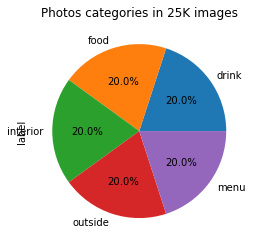

In [10]:
# Plot pie chart to check the balanced distribution
df.label.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Photos categories in 25K images')
plt.show()

In [11]:
df['photo_id']=df['photo_id'].astype(str) + '.jpg'

In [12]:
df.head()

,photo_id,label,business_id,caption
0,Un_Og6jfhazVn7CxszkKEw.jpg,drink,R1sIqGfKpF5f3HV3vyNsbg,Drinks! Front is beer obviously. The pink one ...
1,BFE1AFOs27scnnfeBf99ZA.jpg,drink,vdT7zlrLB2DL9pStDUs91A,
2,7t-C0r1JRdoVD9FS7M-N7Q.jpg,drink,c5GzrObEdj7eNVOdAxrppg,Stella on draft
3,rLnw0d-YYZvT9kR4y7h7_Q.jpg,drink,aQa7N5ZbPhCoKYGGB-gqfg,
4,Cv5M8MDw8a5NEWvw2AQ4nw.jpg,drink,B-s6qOFD75syhwWjp518aA,


In [13]:
X= df.sample(8000,random_state=42)

In [14]:
X.head()

,photo_id,label,business_id,caption
120252,9mrhXqpy4z18u6iz1rpYNQ.jpg,outside,2trWtHH6UCCqP8FIfnoYig,
80684,d7DYRmXGCWjwzKnI0B3Qgw.jpg,interior,ALYQ-uM_uMkKbkXlhWcgbQ,Dining area
1731,32DDYI9zjnd-R-fTpRhPiQ.jpg,drink,KIHoGUfCOLhBFQVSAN4QSg,
80742,eqZ0OgBtys-m2Vll0TXmjw.jpg,interior,fiH__T6XMyhaom2F_5RIEA,Kitchen
80521,LKMDmaF7kRSJRul7E8GyTA.jpg,interior,_su2RkbR-Z8Ppvho4DJbtw,


In [15]:
X.duplicated().sum()

0

In [16]:
X.shape

(8000, 4)

In [17]:
X.label.value_counts()

food        1617
interior    1603
drink       1600
menu        1599
outside     1581
Name: label, dtype: int64

In [18]:
X=X[['photo_id', 'label']]
X = X.reset_index(drop=True)
X.head()

,photo_id,label
0,9mrhXqpy4z18u6iz1rpYNQ.jpg,outside
1,d7DYRmXGCWjwzKnI0B3Qgw.jpg,interior
2,32DDYI9zjnd-R-fTpRhPiQ.jpg,drink
3,eqZ0OgBtys-m2Vll0TXmjw.jpg,interior
4,LKMDmaF7kRSJRul7E8GyTA.jpg,interior


In [19]:
len(X)

8000

### Now we are going to create the train, test and validation datasets

In [20]:
from sklearn.model_selection import train_test_split

# Create first validation set with the whole dataset
train, df_valid = train_test_split(X, test_size=1000,
                                   random_state=42,
                                   stratify=X['label'])

In [21]:
len(train), len(df_valid)

(7000, 1000)

In [22]:
# Create test and training set with the remaining dataset
df_train, df_test = train_test_split(train,
                                     test_size=1000,
                                     random_state=42,
                                     stratify=train['label'])

In [23]:
len(df_train), len(df_valid)

(6000, 1000)

In [24]:
df_train['label'].value_counts()

food        1213
interior    1203
drink       1200
menu        1199
outside     1185
Name: label, dtype: int64

In [25]:
df_test['label'].value_counts()

food        202
interior    200
menu        200
drink       200
outside     198
Name: label, dtype: int64

In [26]:
df_valid['label'].value_counts()

food        202
drink       200
interior    200
menu        200
outside     198
Name: label, dtype: int64

### More or less all the datasets are balanced

In [5]:
folder = Path('SSban')
img_folder = Path(folder/'yelp_photos/photos')
train_folder = Path(folder/'yelp_photos/photos/train_dir')
test_folder = Path(folder/'yelp_photos/photos/test_dir')
valid_folder = Path(folder/'yelp_photos/photos/valid_dir')

In [28]:
# Reset and set index based on column
df_train = df_train.sort_values(by=['photo_id'], ignore_index=True)
df_test = df_test.sort_values(by=['photo_id'], ignore_index=True)
df_valid = df_valid.sort_values(by=['photo_id'], ignore_index=True)

In [30]:
# #Save to CSV file
# df_train.to_csv((folder/'df_train.csv'), index=False)
# df_test.to_csv((folder/'df_test.csv'), index=False)
# df_valid.to_csv((folder/'df_valid.csv'), index=False)

In [31]:
df_train = pd.read_csv(folder/'df_train.csv')
df_test = pd.read_csv(folder/'df_test.csv')
df_valid = pd.read_csv(folder/'df_valid.csv')

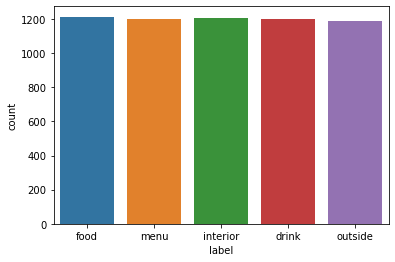

In [32]:
sns.countplot(x="label", data=df_train);

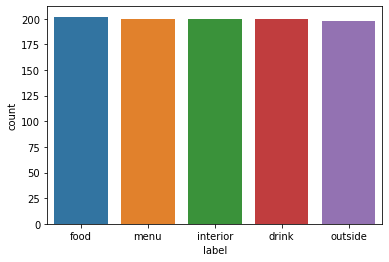

In [33]:
sns.countplot(x="label", data=df_test);

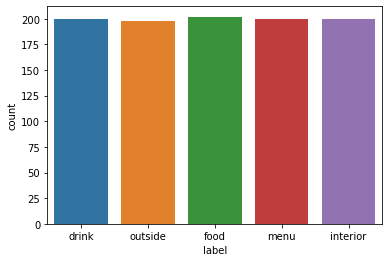

In [34]:
sns.countplot(x="label", data=df_valid);

In [35]:
class_names = list(X.label.unique())
class_names

['outside', 'interior', 'drink', 'food', 'menu']

In [37]:
# CREATE TRAIN DATASET
#Loop over the image filenames by class labels
for c in class_names:
    #by class labels, loop through image name
    for img in list(df_train[df_train.label == c]['photo_id']):
        # Get the path to image at source directory
        get_img = img_folder/img
        # Move the image to destination directory
        move_img_to_categ = shutil.move(str(get_img), str(train_folder/c))

In [38]:
# CREATE TEST DATASET
# Loop over the image filenames by class labels
for c in class_names:
    #by class labels, loop through image name
    for img in list(df_test[df_test.label == c]['photo_id']):
        # Get the path to image at source directory
        get_img = img_folder/img
        # Move the image to destination directory
        move_img_to_categ = shutil.move(str(get_img), str(test_folder/c))

In [39]:
# CREATE VALIDATION DATASET
# # Loop over the image filenames by class labels
for c in class_names:
    #by class labels, loop through image name
    for img in list(df_valid[df_valid.label == c]['photo_id']):
        # Get the path to image at source directory
        get_img = img_folder/img
        # Move the image to destination directory
        move_img_to_categ = shutil.move(str(get_img), str(valid_folder/c))

### Check the number of images in each folder

In [6]:
number_image = len(list(train_folder.glob('*/*.jpg')))
print('Train Folder: ', number_image)

Train Folder:  6000


In [7]:
number_image = len(list(test_folder.glob('*/*.jpg')))
print('Test Folder: ', number_image)

Test Folder:  1000


In [8]:
number_image = len(list(valid_folder.glob('*/*.jpg')))
print('Validation Folder: ', number_image)

Validation Folder:  1000


### Plot some of the pictures from the train folder

In [33]:
# Count of images from the interior subfolder. 
interior = list(train_folder.glob('interior/*'))
len(interior)

1203

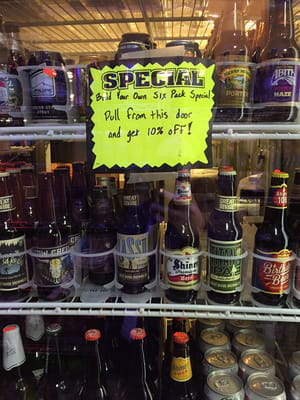

In [36]:
# Plot the first image in the interior folder,
img=PIL.Image.open(str(interior[0]))
display(img)

### Plot the image matrix

In [37]:
image_array = np.array(img)
image_array
print(image_array.shape)

(400, 300, 3)


## Size of the image

In [38]:
h, w, c = image_array.shape
print('height: ', h)
print('width:  ', w)
print('channel:', c)

height:  400
width:   300
channel: 3


### Plot Some of the images in the train folder/meanu

In [39]:
# Plot some images from the interior subfolder. 
menu = list(train_folder.glob('menu/*'))
len(menu)

1199

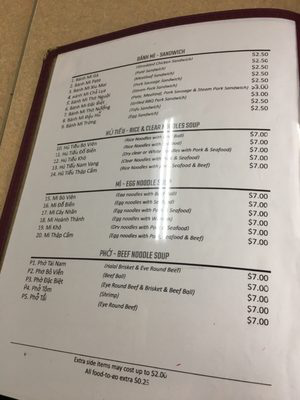

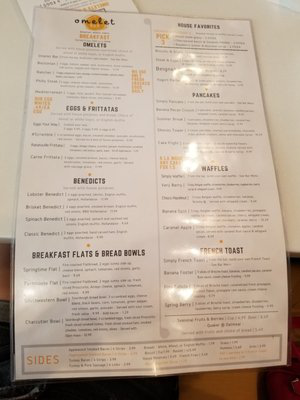

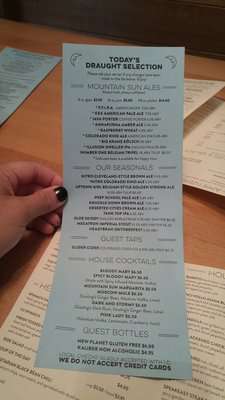

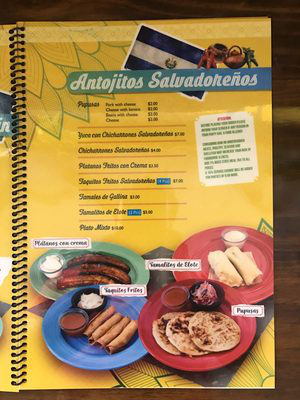

In [41]:
for i in range(4):
    img_i=PIL.Image.open(str(menu[i]))
    display(img_i)   